C:\Users\BiXY\anaconda3\envs\mmcv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['0.Rice', '1.Drink', '2.Green Leaf Vegetables', '3.Meat', '4.Noodles']
[tensor([[[[ 0.0118,  0.0118,  0.0118,  ..., -0.0353, -0.0353, -0.0353],
          [ 0.0118,  0.0118,  0.0118,  ..., -0.0353, -0.0353, -0.0353],
          [ 0.0118,  0.0118,  0.0118,  ..., -0.0431, -0.0353, -0.0431],
          ...,
          [-0.2157, -0.2157, -0.2157,  ..., -0.2157, -0.2157, -0.2235],
          [-0.2235, -0.2157, -0.2157,  ..., -0.2471, -0.2471, -0.2471],
          [-0.2235, -0.2314, -0.2235,  ..., -0.2627, -0.2627, -0.2627]],

         [[-0.2314, -0.2314, -0.2314,  ..., -0.2627, -0.2627, -0.2627],
          [-0.2314, -0.2314, -0.2314,  ..., -0.2627, -0.2627, -0.2627],
          [-0.2314, -0.2314, -0.2314,  ..., -0.2627, -0.2627, -0.2627],
          ...,
          [-0.1137, -0.1137, -0.1137,  ..., -0.0980, -0.0902, -0.0980],
          [-0.1216, -0.1216, -0.1137,  ..., -0.1216, -0.1216, -0.1216],
          [-0.1216, -0.1294, -0.1216,  ..., -0.1451, -0.1373, -0.1373]],

         [[-0.2078, -0.2078, 

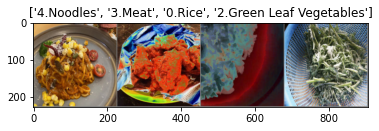

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import copy       # helps to make copies instead of references
import time
from tqdm.auto import tqdm

random.seed(1)
food_label = {"0.Rice": 0, "1.Drink": 1, "2.Green Leaf Vegetables": 2, "3.Meat": 3, "4.Noodles": 4}


# class Food_Dataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         """
#         Food分类任务的Dataset
#         :param data_dir: str, 数据集所在路径
#         :param transform: torch.transform，数据预处理
#         """
#         self.label_name = {"0.Rice": 0, "1.Drink": 1, "2.Green Leaf Vegetables": 2, "3.Meat": 3, "4.Noodles": 4}
#         self.data_info = self.get_img_info(data_dir)  # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
#         self.transform = transform
#
#     def __getitem__(self, index):
#         path_img, label = self.data_info[index]
#         img = Image.open(path_img).convert('RGB')     # 0~255
#
#         if self.transform is not None:
#             img = self.transform(img)   # 在这里做transform，转为tensor等等
#
#         return img, label
#
#     def __len__(self):
#         return len(self.data_info)
#
#     @staticmethod
#     def get_img_info(data_dir):
#         data_info = list()
#         for root, dirs, _ in os.walk(data_dir):
#             # 遍历类别
#             for sub_dir in dirs:
#                 img_names = os.listdir(os.path.join(root, sub_dir))
#                 img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
#
#                 # 遍历图片
#                 for i in range(len(img_names)):
#                     img_name = img_names[i]
#                     path_img = os.path.join(root, sub_dir, img_name)
#                     label = food_label[sub_dir]
#                     data_info.append((path_img, int(label)))
#
#         return data_info
#
# food_dataset = Food_Dataset(r'C:\Users\BiXY\OneDrive - 厦门大学(马来西亚分校)\AIT202\Project\Food_Dataset')

# transform setting
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

data_transform = {
    'train': transforms.Compose([
        transforms.AutoAugment(),
        transforms.RandomResizedCrop(224), # 224 x 224 shrink the picture
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Normalize to [0.0,1.0]
        transforms.Normalize(mean, std) # 数据中的每个值就变成了[-1,1]的数
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # crop it from the middle
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # crop it from the middle
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


batch_size = 4
data_dir = r'C:\Users\BiXY\OneDrive - 厦门大学(马来西亚分校)\AIT202\Project\Food_Dataset_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(class_names)

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = std*img + mean
    plt.imshow(img)
    plt.title(title)
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
print(next(iter(dataloaders['train'])))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BasicBlock_moveBN(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_moveBN, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, in_planes, planes, stride=1):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(self.expansion * planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = F.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


class ResNet_moveBN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet_moveBN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18_original():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet18_move_BN():
    return ResNet_moveBN(BasicBlock_moveBN, [2, 2, 2, 2])

def ResNet34_original():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet34_move_BN():
    return ResNet_moveBN(BasicBlock_moveBN, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())

In [3]:
from collections import OrderedDict

# 将Conv+BN封装成一个基础卷积类：
class BasicConv2d_moveBN(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d_moveBN, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size,
                      stride=stride, padding=padding, bias=False)

    def forward(self, x):
        x = self.conv(x)
        return x
    
# 一个Bottleneck模块:
class Bottleneck_moveBN(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, stride=1):
        super(Bottleneck_moveBN, self).__init__()

        self.judge = in_channel == out_channel

        self.bottleneck = nn.Sequential(OrderedDict([
            ('Conv1',BasicConv2d_moveBN(in_channel, mid_channel, 1)),
            ('Relu1',nn.ReLU(True)),
            ('Conv2',BasicConv2d_moveBN(mid_channel, mid_channel, 3, padding=1, stride=stride)),
            ('Relu2',nn.ReLU(True)),
            ('Conv3',BasicConv2d_moveBN(mid_channel, out_channel, 1)),]
        ))
        self.relu = nn.ReLU(True)
        # 下采样部分由一个包含BN层的1x1卷积构成：
        if in_channel != out_channel:
            self.downsample = BasicConv2d_moveBN(
                in_channel, out_channel, 1, stride=stride)

    def forward(self, x):
        out = self.bottleneck(x)
        # 若通道不一致需使用1x1卷积下采样
        if not self.judge:
            self.identity = self.downsample(x)
            # 残差+恒等映射=输出
            out += self.identity
        # 否则直接相加
        else:
            out += x

        out = self.relu(out)

        return out

# Modified Resnet50:
class ResNet_50_modified(nn.Module):
    def __init__(self, class_num):
        super(ResNet_50_modified, self).__init__()
        self.conv = BasicConv2d_moveBN(3, 64, 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        # 卷积组1
        self.block1 = nn.Sequential(
            Bottleneck_moveBN(64, 64, 256),
            Bottleneck_moveBN(256, 64, 256),
            Bottleneck_moveBN(256, 64, 256),
        )
        # 卷积组2
        self.block2 = nn.Sequential(
            Bottleneck_moveBN(256, 128, 512, stride=2),
            Bottleneck_moveBN(512, 128, 512),
            Bottleneck_moveBN(512, 128, 512),
            Bottleneck_moveBN(512, 128, 512),
        )
#         # 卷积组3
#         self.block3 = nn.Sequential(
#             Bottleneck(512, 256, 1024, stride=2),
#             Bottleneck(1024, 256, 1024),
#             Bottleneck(1024, 256, 1024),
#             Bottleneck(1024, 256, 1024),
#             Bottleneck(1024, 256, 1024),
#             Bottleneck(1024, 256, 1024),
#         )
#         # 卷积组4
#         self.block4 = nn.Sequential(
#             Bottleneck(1024, 512, 2048, stride=2),
#             Bottleneck(2048, 512, 2048),
#             Bottleneck(2048, 512, 2048),
#         )
        self.avgpool = nn.AvgPool2d(4)
        self.classifier = nn.Linear(25088, class_num)

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)

        return out

In [4]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [5]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [7]:
# The number of training epochs.
n_epochs = 80
t_loss1 = []
t_acc1 = []
v_loss1 = []
v_acc1 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss1.append(train_loss)
    t_acc1.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss1.append(valid_loss)
    v_acc1.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.96it/s]


[ Train | 001/080 ] loss = 1.52971, acc = 0.34574


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.02it/s]


[ Valid | 001/080 ] loss = 1.32006, acc = 0.52500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 002/080 ] loss = 1.47036, acc = 0.37899


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]


[ Valid | 002/080 ] loss = 1.35008, acc = 0.45000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.20it/s]


[ Train | 003/080 ] loss = 1.47039, acc = 0.38032


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]


[ Valid | 003/080 ] loss = 1.20573, acc = 0.51000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 004/080 ] loss = 1.39581, acc = 0.41755


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.73it/s]


[ Valid | 004/080 ] loss = 1.25137, acc = 0.48000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.18it/s]


[ Train | 005/080 ] loss = 1.39917, acc = 0.41090


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 005/080 ] loss = 1.20315, acc = 0.56000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 006/080 ] loss = 1.45101, acc = 0.40160


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 006/080 ] loss = 1.14932, acc = 0.57500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.98it/s]


[ Train | 007/080 ] loss = 1.33353, acc = 0.43750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


[ Valid | 007/080 ] loss = 1.12974, acc = 0.54000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 008/080 ] loss = 1.31855, acc = 0.45878


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


[ Valid | 008/080 ] loss = 1.02169, acc = 0.61000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.94it/s]


[ Train | 009/080 ] loss = 1.32153, acc = 0.47074


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.00it/s]


[ Valid | 009/080 ] loss = 1.04829, acc = 0.57500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 010/080 ] loss = 1.30022, acc = 0.46941


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


[ Valid | 010/080 ] loss = 1.18656, acc = 0.47500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 011/080 ] loss = 1.25374, acc = 0.48537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


[ Valid | 011/080 ] loss = 0.99574, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.30it/s]


[ Train | 012/080 ] loss = 1.27664, acc = 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 012/080 ] loss = 1.03924, acc = 0.58500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.09it/s]


[ Train | 013/080 ] loss = 1.23626, acc = 0.52394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 013/080 ] loss = 1.12317, acc = 0.56000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 014/080 ] loss = 1.22810, acc = 0.48537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


[ Valid | 014/080 ] loss = 0.90304, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.30it/s]


[ Train | 015/080 ] loss = 1.23038, acc = 0.49069


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 015/080 ] loss = 1.00802, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 016/080 ] loss = 1.25281, acc = 0.49867


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.29it/s]


[ Valid | 016/080 ] loss = 0.93646, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.91it/s]


[ Train | 017/080 ] loss = 1.22626, acc = 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 017/080 ] loss = 0.99064, acc = 0.60000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.06it/s]


[ Train | 018/080 ] loss = 1.22403, acc = 0.50665


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.58it/s]


[ Valid | 018/080 ] loss = 0.95760, acc = 0.66500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.08it/s]


[ Train | 019/080 ] loss = 1.19495, acc = 0.52128


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 019/080 ] loss = 0.99019, acc = 0.64000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.24it/s]


[ Train | 020/080 ] loss = 1.22217, acc = 0.50798


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


[ Valid | 020/080 ] loss = 1.08891, acc = 0.54000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 021/080 ] loss = 1.18699, acc = 0.52660


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.64it/s]


[ Valid | 021/080 ] loss = 1.02153, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.35it/s]


[ Train | 022/080 ] loss = 1.16138, acc = 0.54388


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.72it/s]


[ Valid | 022/080 ] loss = 0.88331, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.15it/s]


[ Train | 023/080 ] loss = 1.16009, acc = 0.52926


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 023/080 ] loss = 0.88036, acc = 0.70500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 024/080 ] loss = 1.12518, acc = 0.55452


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 024/080 ] loss = 1.12343, acc = 0.59500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 025/080 ] loss = 1.11414, acc = 0.56516


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.04it/s]


[ Valid | 025/080 ] loss = 0.91001, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 026/080 ] loss = 1.13525, acc = 0.54255


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]


[ Valid | 026/080 ] loss = 0.87735, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 027/080 ] loss = 1.08597, acc = 0.56117


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.41it/s]


[ Valid | 027/080 ] loss = 0.85358, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.06it/s]


[ Train | 028/080 ] loss = 1.07103, acc = 0.56250


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


[ Valid | 028/080 ] loss = 0.92145, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.18it/s]


[ Train | 029/080 ] loss = 1.12857, acc = 0.54654


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 029/080 ] loss = 0.79230, acc = 0.73000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 030/080 ] loss = 1.10154, acc = 0.54122


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


[ Valid | 030/080 ] loss = 0.84994, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 031/080 ] loss = 1.05984, acc = 0.56649


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]


[ Valid | 031/080 ] loss = 0.75691, acc = 0.75000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 032/080 ] loss = 1.04143, acc = 0.59441


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.29it/s]


[ Valid | 032/080 ] loss = 0.82571, acc = 0.67000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.08it/s]


[ Train | 033/080 ] loss = 0.98644, acc = 0.60904


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.76it/s]


[ Valid | 033/080 ] loss = 0.76239, acc = 0.70500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 034/080 ] loss = 0.95326, acc = 0.62766


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 034/080 ] loss = 0.80205, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.18it/s]


[ Train | 035/080 ] loss = 0.96523, acc = 0.63032


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]


[ Valid | 035/080 ] loss = 0.75600, acc = 0.72500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 036/080 ] loss = 1.01100, acc = 0.59840


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 036/080 ] loss = 0.90211, acc = 0.67500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.92it/s]


[ Train | 037/080 ] loss = 0.96462, acc = 0.63963


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.61it/s]


[ Valid | 037/080 ] loss = 0.72192, acc = 0.74000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.26it/s]


[ Train | 038/080 ] loss = 0.93959, acc = 0.63830


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 038/080 ] loss = 0.77120, acc = 0.72000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.02it/s]


[ Train | 039/080 ] loss = 0.99653, acc = 0.59707


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 039/080 ] loss = 0.74490, acc = 0.76000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:42<00:00,  4.42it/s]


[ Train | 040/080 ] loss = 0.89080, acc = 0.64628


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 040/080 ] loss = 0.79208, acc = 0.75500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.98it/s]


[ Train | 041/080 ] loss = 0.93018, acc = 0.62633


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 041/080 ] loss = 0.73924, acc = 0.74500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 042/080 ] loss = 1.02932, acc = 0.62234


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


[ Valid | 042/080 ] loss = 0.76072, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.24it/s]


[ Train | 043/080 ] loss = 0.94475, acc = 0.64362


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.71it/s]


[ Valid | 043/080 ] loss = 0.76325, acc = 0.71500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.24it/s]


[ Train | 044/080 ] loss = 0.93780, acc = 0.64229


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.66it/s]


[ Valid | 044/080 ] loss = 0.68395, acc = 0.78000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 045/080 ] loss = 0.86678, acc = 0.66223


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.10it/s]


[ Valid | 045/080 ] loss = 0.68928, acc = 0.75000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.05it/s]


[ Train | 046/080 ] loss = 0.97334, acc = 0.62766


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 046/080 ] loss = 0.74977, acc = 0.72000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.18it/s]


[ Train | 047/080 ] loss = 0.91992, acc = 0.63165


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.38it/s]


[ Valid | 047/080 ] loss = 0.83720, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.01it/s]


[ Train | 048/080 ] loss = 0.95036, acc = 0.64495


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 048/080 ] loss = 0.70080, acc = 0.76500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.30it/s]


[ Train | 049/080 ] loss = 0.94321, acc = 0.65691


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


[ Valid | 049/080 ] loss = 0.75856, acc = 0.75000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.08it/s]


[ Train | 050/080 ] loss = 0.87712, acc = 0.68218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.12it/s]


[ Valid | 050/080 ] loss = 0.63236, acc = 0.78500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.02it/s]


[ Train | 051/080 ] loss = 0.91648, acc = 0.66888


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.66it/s]


[ Valid | 051/080 ] loss = 0.81867, acc = 0.72500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 052/080 ] loss = 0.85312, acc = 0.68883


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


[ Valid | 052/080 ] loss = 0.70175, acc = 0.76500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.31it/s]


[ Train | 053/080 ] loss = 0.85853, acc = 0.69149


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.86it/s]


[ Valid | 053/080 ] loss = 1.44713, acc = 0.51500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.08it/s]


[ Train | 054/080 ] loss = 0.94356, acc = 0.65559


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.90it/s]


[ Valid | 054/080 ] loss = 0.75437, acc = 0.74000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.21it/s]


[ Train | 055/080 ] loss = 0.85038, acc = 0.69282


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


[ Valid | 055/080 ] loss = 0.69991, acc = 0.77000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 056/080 ] loss = 0.81337, acc = 0.69016


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.36it/s]


[ Valid | 056/080 ] loss = 0.67845, acc = 0.77000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 057/080 ] loss = 0.79560, acc = 0.71676


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.93it/s]


[ Valid | 057/080 ] loss = 0.75335, acc = 0.72500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 058/080 ] loss = 0.90170, acc = 0.66622


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


[ Valid | 058/080 ] loss = 0.68633, acc = 0.74500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 059/080 ] loss = 0.87431, acc = 0.68085


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.72it/s]


[ Valid | 059/080 ] loss = 0.60789, acc = 0.79500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 060/080 ] loss = 0.87807, acc = 0.66090


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.68it/s]


[ Valid | 060/080 ] loss = 0.72903, acc = 0.75000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 061/080 ] loss = 0.84028, acc = 0.67420


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.27it/s]


[ Valid | 061/080 ] loss = 0.74855, acc = 0.71000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 062/080 ] loss = 0.85650, acc = 0.68750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.59it/s]


[ Valid | 062/080 ] loss = 0.59617, acc = 0.79000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.05it/s]


[ Train | 063/080 ] loss = 0.82665, acc = 0.69282


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


[ Valid | 063/080 ] loss = 0.90908, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 064/080 ] loss = 0.86319, acc = 0.67819


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.75it/s]


[ Valid | 064/080 ] loss = 0.67144, acc = 0.78000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 065/080 ] loss = 0.82366, acc = 0.70745


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.46it/s]


[ Valid | 065/080 ] loss = 0.72214, acc = 0.79500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 066/080 ] loss = 0.83341, acc = 0.68883


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.01it/s]


[ Valid | 066/080 ] loss = 0.95986, acc = 0.70500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.02it/s]


[ Train | 067/080 ] loss = 0.79650, acc = 0.71410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 067/080 ] loss = 0.76147, acc = 0.74500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.20it/s]


[ Train | 068/080 ] loss = 0.78975, acc = 0.69947


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.49it/s]


[ Valid | 068/080 ] loss = 0.61571, acc = 0.80500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 069/080 ] loss = 0.83612, acc = 0.70612


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]


[ Valid | 069/080 ] loss = 0.69734, acc = 0.75500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 070/080 ] loss = 0.82911, acc = 0.68883


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.94it/s]


[ Valid | 070/080 ] loss = 0.60579, acc = 0.80500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.32it/s]


[ Train | 071/080 ] loss = 0.76026, acc = 0.72739


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


[ Valid | 071/080 ] loss = 0.63550, acc = 0.79000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.95it/s]


[ Train | 072/080 ] loss = 0.73966, acc = 0.73537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.17it/s]


[ Valid | 072/080 ] loss = 0.71150, acc = 0.74000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.10it/s]


[ Train | 073/080 ] loss = 0.80228, acc = 0.71543


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 073/080 ] loss = 0.69866, acc = 0.76000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.87it/s]


[ Train | 074/080 ] loss = 0.80394, acc = 0.71543


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.49it/s]


[ Valid | 074/080 ] loss = 0.79845, acc = 0.75000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 075/080 ] loss = 0.77409, acc = 0.71144


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 075/080 ] loss = 0.77734, acc = 0.74000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 076/080 ] loss = 0.81998, acc = 0.69016


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.61it/s]


[ Valid | 076/080 ] loss = 0.61474, acc = 0.78500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.18it/s]


[ Train | 077/080 ] loss = 0.73379, acc = 0.72340


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.79it/s]


[ Valid | 077/080 ] loss = 0.56743, acc = 0.81000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.02it/s]


[ Train | 078/080 ] loss = 0.80989, acc = 0.70878


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.58it/s]


[ Valid | 078/080 ] loss = 0.60184, acc = 0.81000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.22it/s]


[ Train | 079/080 ] loss = 0.83489, acc = 0.69814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.52it/s]


[ Valid | 079/080 ] loss = 0.87826, acc = 0.69000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:43<00:00,  4.28it/s]


[ Train | 080/080 ] loss = 0.80278, acc = 0.70878


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.37it/s]

[ Valid | 080/080 ] loss = 0.60989, acc = 0.80000


In [8]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.74it/s]

Accuracy of the network: 76.0 %
Accuracy of 0.Rice: 82.5 % 
Accuracy of 1.Drink: 87.5 % 
Accuracy of 2.Green Leaf Vegetables: 95.0 % 
Accuracy of 3.Meat: 52.5 % 
Accuracy of 4.Noodles: 62.5 % 


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)

In [12]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [13]:
# The number of training epochs.
n_epochs = 80
t_loss2 = []
t_acc2 = []
v_loss2 = []
v_acc2 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss2.append(train_loss)
    t_acc2.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss2.append(valid_loss)
    v_acc2.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.18it/s]


[ Train | 001/080 ] loss = 4.23112, acc = 0.20479


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.63it/s]


[ Valid | 001/080 ] loss = 2.13797, acc = 0.23000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.13it/s]


[ Train | 002/080 ] loss = 1.76597, acc = 0.19548


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


[ Valid | 002/080 ] loss = 4.98951, acc = 0.28500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.22it/s]


[ Train | 003/080 ] loss = 1.67710, acc = 0.21410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


[ Valid | 003/080 ] loss = 1.63177, acc = 0.21500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.20it/s]


[ Train | 004/080 ] loss = 1.65534, acc = 0.21011


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 004/080 ] loss = 1.61895, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 005/080 ] loss = 1.63362, acc = 0.22074


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.10it/s]


[ Valid | 005/080 ] loss = 1.61450, acc = 0.34000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.05it/s]


[ Train | 006/080 ] loss = 1.63770, acc = 0.23670


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 006/080 ] loss = 1.70257, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.18it/s]


[ Train | 007/080 ] loss = 1.67161, acc = 0.19947


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


[ Valid | 007/080 ] loss = 1.55989, acc = 0.27000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 008/080 ] loss = 1.67114, acc = 0.20878


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]


[ Valid | 008/080 ] loss = 1.62502, acc = 0.28000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.18it/s]


[ Train | 009/080 ] loss = 1.61637, acc = 0.28723


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


[ Valid | 009/080 ] loss = 1.47294, acc = 0.35500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


[ Train | 010/080 ] loss = 1.59601, acc = 0.26197


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.52it/s]


[ Valid | 010/080 ] loss = 1.45124, acc = 0.39500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


[ Train | 011/080 ] loss = 1.58300, acc = 0.25798


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]


[ Valid | 011/080 ] loss = 1.43298, acc = 0.37000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.14it/s]


[ Train | 012/080 ] loss = 1.55866, acc = 0.29255


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.18it/s]


[ Valid | 012/080 ] loss = 1.41511, acc = 0.44500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 013/080 ] loss = 1.53645, acc = 0.31782


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.49it/s]


[ Valid | 013/080 ] loss = 1.35277, acc = 0.38000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.10it/s]


[ Train | 014/080 ] loss = 1.53830, acc = 0.30585


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


[ Valid | 014/080 ] loss = 1.38137, acc = 0.46500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 015/080 ] loss = 1.65198, acc = 0.29521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


[ Valid | 015/080 ] loss = 1.68005, acc = 0.32500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


[ Train | 016/080 ] loss = 1.59973, acc = 0.30718


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


[ Valid | 016/080 ] loss = 1.76670, acc = 0.36500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 017/080 ] loss = 1.58761, acc = 0.28191


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 017/080 ] loss = 1.39925, acc = 0.44000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.10it/s]


[ Train | 018/080 ] loss = 1.50764, acc = 0.32846


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.46it/s]


[ Valid | 018/080 ] loss = 1.32506, acc = 0.41500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.03it/s]


[ Train | 019/080 ] loss = 1.49872, acc = 0.34840


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.15it/s]


[ Valid | 019/080 ] loss = 1.89417, acc = 0.35500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 020/080 ] loss = 1.46954, acc = 0.37234


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]


[ Valid | 020/080 ] loss = 1.22435, acc = 0.53500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.07it/s]


[ Train | 021/080 ] loss = 1.47869, acc = 0.36968


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.82it/s]


[ Valid | 021/080 ] loss = 1.30193, acc = 0.46500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.13it/s]


[ Train | 022/080 ] loss = 1.46904, acc = 0.38697


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.41it/s]


[ Valid | 022/080 ] loss = 1.20580, acc = 0.50500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 023/080 ] loss = 1.43009, acc = 0.39761


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 023/080 ] loss = 1.07541, acc = 0.58000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 024/080 ] loss = 1.44535, acc = 0.39628


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 024/080 ] loss = 1.52162, acc = 0.52000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.11it/s]


[ Train | 025/080 ] loss = 1.52940, acc = 0.36037


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]


[ Valid | 025/080 ] loss = 2.86523, acc = 0.45500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.05it/s]


[ Train | 026/080 ] loss = 1.66756, acc = 0.35505


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.12it/s]


[ Valid | 026/080 ] loss = 1.10008, acc = 0.58000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


[ Train | 027/080 ] loss = 1.39204, acc = 0.41090


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


[ Valid | 027/080 ] loss = 0.95309, acc = 0.63000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


[ Train | 028/080 ] loss = 1.46071, acc = 0.40426


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.52it/s]


[ Valid | 028/080 ] loss = 2.28885, acc = 0.43000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.86it/s]


[ Train | 029/080 ] loss = 1.41953, acc = 0.37633


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]


[ Valid | 029/080 ] loss = 1.45315, acc = 0.59500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.81it/s]


[ Train | 030/080 ] loss = 1.36435, acc = 0.43750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


[ Valid | 030/080 ] loss = 1.13934, acc = 0.52000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.01it/s]


[ Train | 031/080 ] loss = 1.39549, acc = 0.44947


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.06it/s]


[ Valid | 031/080 ] loss = 2.49905, acc = 0.57500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


[ Train | 032/080 ] loss = 1.45009, acc = 0.40027


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.38it/s]


[ Valid | 032/080 ] loss = 1.31508, acc = 0.52000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


[ Train | 033/080 ] loss = 1.38299, acc = 0.42553


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


[ Valid | 033/080 ] loss = 0.98392, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.08it/s]


[ Train | 034/080 ] loss = 1.41088, acc = 0.41489


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


[ Valid | 034/080 ] loss = 1.02208, acc = 0.61000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.94it/s]


[ Train | 035/080 ] loss = 1.33873, acc = 0.45612


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.82it/s]


[ Valid | 035/080 ] loss = 1.07716, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


[ Train | 036/080 ] loss = 1.31178, acc = 0.46410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


[ Valid | 036/080 ] loss = 1.08530, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.00it/s]


[ Train | 037/080 ] loss = 1.35136, acc = 0.45080


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


[ Valid | 037/080 ] loss = 0.96828, acc = 0.57500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 038/080 ] loss = 1.34219, acc = 0.44814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.51it/s]


[ Valid | 038/080 ] loss = 1.20482, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.17it/s]


[ Train | 039/080 ] loss = 1.38121, acc = 0.42819


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]


[ Valid | 039/080 ] loss = 1.05201, acc = 0.55500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.18it/s]


[ Train | 040/080 ] loss = 1.36290, acc = 0.45213


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


[ Valid | 040/080 ] loss = 1.20861, acc = 0.56500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


[ Train | 041/080 ] loss = 1.37690, acc = 0.44415


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.86it/s]


[ Valid | 041/080 ] loss = 1.22460, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.11it/s]


[ Train | 042/080 ] loss = 1.28935, acc = 0.47340


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.23it/s]


[ Valid | 042/080 ] loss = 0.99724, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.19it/s]


[ Train | 043/080 ] loss = 1.25606, acc = 0.48271


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]


[ Valid | 043/080 ] loss = 1.01198, acc = 0.59500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.10it/s]


[ Train | 044/080 ] loss = 1.22142, acc = 0.49867


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.74it/s]


[ Valid | 044/080 ] loss = 1.23154, acc = 0.58000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 045/080 ] loss = 1.26148, acc = 0.49601


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


[ Valid | 045/080 ] loss = 1.00068, acc = 0.68000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.96it/s]


[ Train | 046/080 ] loss = 1.23420, acc = 0.50266


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


[ Valid | 046/080 ] loss = 0.90745, acc = 0.63000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.18it/s]


[ Train | 047/080 ] loss = 1.34788, acc = 0.44814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.30it/s]


[ Valid | 047/080 ] loss = 2.02475, acc = 0.53500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.00it/s]


[ Train | 048/080 ] loss = 1.32270, acc = 0.46011


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


[ Valid | 048/080 ] loss = 1.24063, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.08it/s]


[ Train | 049/080 ] loss = 1.33549, acc = 0.46277


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


[ Valid | 049/080 ] loss = 1.49090, acc = 0.52000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.06it/s]


[ Train | 050/080 ] loss = 1.29846, acc = 0.47473


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 050/080 ] loss = 0.94217, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.10it/s]


[ Train | 051/080 ] loss = 1.23039, acc = 0.49468


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.88it/s]


[ Valid | 051/080 ] loss = 0.85249, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.18it/s]


[ Train | 052/080 ] loss = 1.29478, acc = 0.47473


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


[ Valid | 052/080 ] loss = 1.07492, acc = 0.66500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


[ Train | 053/080 ] loss = 1.23157, acc = 0.51596


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]


[ Valid | 053/080 ] loss = 0.87906, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.21it/s]


[ Train | 054/080 ] loss = 1.18613, acc = 0.52660


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.07it/s]


[ Valid | 054/080 ] loss = 0.93283, acc = 0.62500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.07it/s]


[ Train | 055/080 ] loss = 1.19299, acc = 0.51596


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]


[ Valid | 055/080 ] loss = 0.94648, acc = 0.62500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 056/080 ] loss = 1.22852, acc = 0.50532


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.78it/s]


[ Valid | 056/080 ] loss = 1.19289, acc = 0.60000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.11it/s]


[ Train | 057/080 ] loss = 1.20772, acc = 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s]


[ Valid | 057/080 ] loss = 0.97535, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.03it/s]


[ Train | 058/080 ] loss = 1.22571, acc = 0.50931


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.27it/s]


[ Valid | 058/080 ] loss = 0.79588, acc = 0.71000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.14it/s]


[ Train | 059/080 ] loss = 1.19282, acc = 0.52128


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.18it/s]


[ Valid | 059/080 ] loss = 1.15565, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.07it/s]


[ Train | 060/080 ] loss = 1.19103, acc = 0.53457


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


[ Valid | 060/080 ] loss = 1.00610, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.20it/s]


[ Train | 061/080 ] loss = 1.16967, acc = 0.52394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.05it/s]


[ Valid | 061/080 ] loss = 0.78501, acc = 0.72000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.13it/s]


[ Train | 062/080 ] loss = 1.22062, acc = 0.49734


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.44it/s]


[ Valid | 062/080 ] loss = 0.99919, acc = 0.71500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.12it/s]


[ Train | 063/080 ] loss = 1.23405, acc = 0.49335


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


[ Valid | 063/080 ] loss = 1.10248, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


[ Train | 064/080 ] loss = 1.16843, acc = 0.54521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


[ Valid | 064/080 ] loss = 0.85183, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.07it/s]


[ Train | 065/080 ] loss = 1.15085, acc = 0.53856


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


[ Valid | 065/080 ] loss = 0.92855, acc = 0.68000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.11it/s]


[ Train | 066/080 ] loss = 1.13512, acc = 0.55053


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]


[ Valid | 066/080 ] loss = 0.87498, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.14it/s]


[ Train | 067/080 ] loss = 1.12093, acc = 0.53723


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


[ Valid | 067/080 ] loss = 1.00443, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.14it/s]


[ Train | 068/080 ] loss = 1.22820, acc = 0.51330


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


[ Valid | 068/080 ] loss = 0.88234, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


[ Train | 069/080 ] loss = 1.16089, acc = 0.53457


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.14it/s]


[ Valid | 069/080 ] loss = 1.02462, acc = 0.63000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.03it/s]


[ Train | 070/080 ] loss = 1.20038, acc = 0.50399


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


[ Valid | 070/080 ] loss = 0.87193, acc = 0.67000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 071/080 ] loss = 1.13554, acc = 0.55053


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


[ Valid | 071/080 ] loss = 0.83295, acc = 0.65500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.01it/s]


[ Train | 072/080 ] loss = 1.14641, acc = 0.55053


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


[ Valid | 072/080 ] loss = 0.80673, acc = 0.70500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.06it/s]


[ Train | 073/080 ] loss = 1.15229, acc = 0.53723


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.93it/s]


[ Valid | 073/080 ] loss = 0.88121, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.01it/s]


[ Train | 074/080 ] loss = 1.09846, acc = 0.57048


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.01it/s]


[ Valid | 074/080 ] loss = 2.15655, acc = 0.65000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


[ Train | 075/080 ] loss = 1.30548, acc = 0.50266


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.10it/s]


[ Valid | 075/080 ] loss = 1.16803, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


[ Train | 076/080 ] loss = 1.23383, acc = 0.52128


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.01it/s]


[ Valid | 076/080 ] loss = 0.76813, acc = 0.71000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.00it/s]


[ Train | 077/080 ] loss = 1.14002, acc = 0.54521


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


[ Valid | 077/080 ] loss = 0.78665, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.88it/s]


[ Train | 078/080 ] loss = 1.11847, acc = 0.54920


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


[ Valid | 078/080 ] loss = 0.84489, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.00it/s]


[ Train | 079/080 ] loss = 1.05857, acc = 0.57447


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


[ Valid | 079/080 ] loss = 0.83910, acc = 0.69500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.98it/s]


[ Train | 080/080 ] loss = 1.09807, acc = 0.56782


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.09it/s]

[ Valid | 080/080 ] loss = 0.87078, acc = 0.66000


In [14]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.44it/s]

Accuracy of the network: 65.0 %
Accuracy of 0.Rice: 15.0 % 
Accuracy of 1.Drink: 90.0 % 
Accuracy of 2.Green Leaf Vegetables: 70.0 % 
Accuracy of 3.Meat: 85.0 % 
Accuracy of 4.Noodles: 65.0 % 


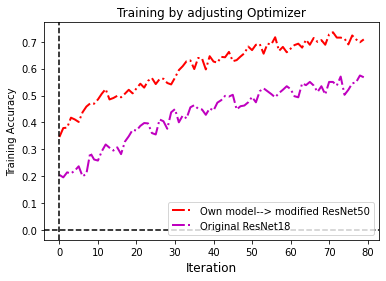

In [15]:
import matplotlib.pyplot as plt
import numpy as np


t_acc1 = torch.tensor(t_acc1, device = 'cpu')
t_acc2 = torch.tensor(t_acc2, device = 'cpu')

plt.plot(t_acc1, color ='r', linestyle = '-.', linewidth=2, label='Own model--> modified ResNet50')
plt.plot(t_acc2, color ='m', linestyle = '-.', linewidth=2, label='Original ResNet18')


#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')#绘制y轴平行线
plt.axhline(0, color='k', linestyle='--')#绘制x轴平行线
plt.title("Training by adjusting Optimizer")#设置标题
plt.xlabel("Iteration", fontsize=12)#x轴名称
plt.ylabel("Training Accuracy")#y轴名称
plt.legend()
plt.show()#显示图像

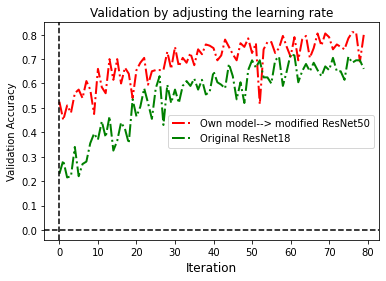

In [16]:
import matplotlib.pyplot as plt
import numpy as np

v_acc1 = torch.tensor(v_acc1, device = 'cpu')
v_acc2 = torch.tensor(v_acc2, device = 'cpu')


plt.plot(v_acc1, color ='r', linestyle = '-.', linewidth=2, label='Own model--> modified ResNet50')
plt.plot(v_acc2, color ='g', linestyle = '-.', linewidth=2, label='Original ResNet18')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')#绘制y轴平行线
plt.axhline(0, color='k', linestyle='--')#绘制x轴平行线
plt.title("Validation by adjusting the learning rate")#设置标题
plt.xlabel("Iteration", fontsize=12)#x轴名称
plt.ylabel("Validation Accuracy")#y轴名称
plt.legend()
plt.show()#显示图像